In [82]:
%pip install -q tensorflow scikit-learn matplotlib pandas numpy

Note: you may need to restart the kernel to use updated packages.


In [83]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, GRU, Bidirectional, Add, Input, Attention, MultiHeadAttention, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K

In [84]:
# Parameters for LSTM workflow
CSV_PATH = 'btc_processed.csv'  # path to your cleaned data file
WINDOW_SIZE = 14  # sequence length
TRAIN_RATIO = 0.8  # chronological split: first 80% train, last 20% test
RANDOM_SEED = 42
TARGET_HORIZON = 7  # predict direction over N days

# Advanced settings
USE_ATTENTION = True  # add attention mechanism
USE_RESIDUAL = True   # residual connections in attention block
USE_FOCAL_LOSS = True # focal loss for class imbalance

df = pd.read_csv(CSV_PATH)

print(f'Window size: {WINDOW_SIZE}')
print(f'Target horizon: {TARGET_HORIZON} day(s)')
print(f'Attention={USE_ATTENTION}, Residual={USE_RESIDUAL}, FocalLoss={USE_FOCAL_LOSS}')

Window size: 14
Target horizon: 7 day(s)
Attention=True, Residual=True, FocalLoss=True


In [99]:
# Feature Selection: Use ALL available features for maximum information
# Including both raw OHLC prices and engineered features

# Exclude date/timestamp, target, and future-leaking columns
exclude = ['Target']
if 'date' in df.columns:
    exclude.append('date')
if 'Date' in df.columns:
    exclude.append('Date')
if 'timestamp' in df.columns:
    exclude.append('timestamp')
# CRITICAL: Exclude future-leaking features that contain information not available at prediction time
if 'next_day_close' in df.columns:
    exclude.append('next_day_close')
    print('⚠️  WARNING: Excluded "next_day_close" to prevent data leakage!')
if 'next_day_open' in df.columns:
    exclude.append('next_day_open')
if 'future_price' in df.columns:
    exclude.append('future_price')

available_cols = [c for c in df.columns if c not in exclude]

# Use ALL available features (excluding leakage)
selected_features = available_cols

print(f'Using {len(selected_features)} features from dataset (after removing leakage):')
print('Features used:', selected_features)
print('\nFeature categories:')
# Categorize features for clarity
raw_ohlc = [f for f in selected_features if f.lower() in ['open', 'high', 'low', 'close']]
volumes = [f for f in selected_features if 'volume' in f.lower()]
engineered = [f for f in selected_features if f not in raw_ohlc + volumes]

if raw_ohlc:
    print(f'  - Raw OHLC prices: {raw_ohlc}')
if volumes:
    print(f'  - Volume features: {volumes}')
if engineered:
    print(f'  - Engineered features: {engineered}')

# X_all = df[selected_features].values.astype(float)
# X_all = df[['open', 'high', 'low', 'close', 'volume', 'rsi_7', 'rsi_14', 'cci_7', 'cci_14', 'sma_50', 'ema_50', 'sma_100', 'ema_100', 'macd', 'bollinger', 'TrueRange', 'atr_7', 'atr_14']].values.astype(float)
# X_all = df[[
#     'Daily_Return',
#     'High_Low_Spread',
#     'Close_Open_Spread',
#     'rsi_7', 'rsi_14',
#     'cci_7', 'cci_14',
#     'macd',
#     'atr_7', 'atr_14',
#     # Only include volume if you normalize it or use log volume
#     'volume' 
# ]].values.astype(float)

# X_all = df[[
#     "rsi_7", "rsi_14", "cci_7", "cci_14", "sma_50", "ema_50",
#     "sma_100", "ema_100", "macd", "bollinger", "TrueRange",
#     "atr_7", "atr_14", "log_open", "log_high", "log_low",
#     "log_close", "log_volume",  "Daily_Return",
#     "High_Low_Spread", "Close_Open_Spread",
#     "log_MA_7", "log_MA_30"
# ]].values.astype(float)

X_all = df[[
    # Raw prices
    # "open", "high", "low", "close", "volume",
    
    # Lagged returns / spreads
    "Daily_Return", "High_Low_Spread", "Close_Open_Spread",
    
    # Technical indicators
    "rsi_7", "rsi_14", "cci_7", "cci_14",
    "sma_50", "ema_50", "sma_100", "ema_100",
    "macd", "bollinger", "TrueRange", "atr_7", "atr_14",
    
    # Log features (optional, may remove if redundant)
    "log_open", "log_high", "log_low", "log_close", "log_volume",
    "log_MA_7", "log_MA_30"
]].values.astype(float)

X_all = df[[
    # --- SAFE FEATURES (Relative/Oscillators) ---
    "Daily_Return", 
    "High_Low_Spread", 
    "Close_Open_Spread",
    
    "rsi_7", "rsi_14", 
    "cci_7", "cci_14",
    "macd", 
    
    # --- TRANSFORMED VOLATILITY (Normalized) ---
    # Divide ATR by Close to make it a percentage (Relative Volatility)
    # If you leave them raw, they will explode as price increases.
    # We create these on the fly if they don't exist:
]].copy()

# Fix ATR/TrueRange to be stationary
X_all['atr_7_pct'] = df['atr_7'] / df['close']
X_all['atr_14_pct'] = df['atr_14'] / df['close']
X_all['truerange_pct'] = df['TrueRange'] / df['close']

# Fix Moving Averages (Distance from MA)
# Instead of raw "50,000", use "Price is 5% above MA"
X_all['dist_sma_50'] = (df['close'] - df['sma_50']) / df['sma_50']
X_all['dist_ema_50'] = (df['close'] - df['ema_50']) / df['ema_50']

# Now select only the final columns
final_features = [
    "Daily_Return", "High_Low_Spread", "Close_Open_Spread",
    "rsi_7", "rsi_14", "cci_7", "cci_14", "macd",
    "atr_7_pct", "atr_14_pct", "truerange_pct",
    "dist_sma_50", "dist_ema_50"
]
X_final = X_all[final_features].values.astype(float)

X_all = X_final


y_all = df['Target']

y_all = df['Target'].values.astype(int)

print(f'\nData shape: {X_all.shape[0]} samples × {X_all.shape[1]} features')

Using 30 features from dataset (after removing leakage):
Features used: ['open', 'high', 'low', 'close', 'volume', 'rsi_7', 'rsi_14', 'cci_7', 'cci_14', 'sma_50', 'ema_50', 'sma_100', 'ema_100', 'macd', 'bollinger', 'TrueRange', 'atr_7', 'atr_14', 'log_open', 'log_high', 'log_low', 'log_close', 'log_volume', 'Daily_Return', 'High_Low_Spread', 'Close_Open_Spread', 'MA_7', 'MA_30', 'log_MA_7', 'log_MA_30']

Feature categories:
  - Raw OHLC prices: ['open', 'high', 'low', 'close']
  - Volume features: ['volume', 'log_volume']
  - Engineered features: ['rsi_7', 'rsi_14', 'cci_7', 'cci_14', 'sma_50', 'ema_50', 'sma_100', 'ema_100', 'macd', 'bollinger', 'TrueRange', 'atr_7', 'atr_14', 'log_open', 'log_high', 'log_low', 'log_close', 'Daily_Return', 'High_Low_Spread', 'Close_Open_Spread', 'MA_7', 'MA_30', 'log_MA_7', 'log_MA_30']

Data shape: 3377 samples × 13 features


## Performance Improvement Summary

**🎯 Key Enhancements Implemented:**

1. **Advanced Model Architecture**
   - Multi-head attention mechanism for better pattern recognition
   - Bidirectional LSTM/GRU to learn forward and backward patterns
   - Layer normalization for stable training
   - Residual connections in attention blocks

2. **Better Loss Function**
   - Focal loss to handle class imbalance more effectively
   - Reduces focus on easy examples, emphasizes hard-to-classify samples

3. **Improved Data Processing**
   - RobustScaler instead of MinMaxScaler (better for crypto volatility)
   - Increased window size to 14 days for richer patterns
   - Removed data leakage (next_day_close excluded)

4. **Optimized Training Strategy**
   - Larger batch size (64) for better gradient estimates
   - Learning rate warmup and scheduling
   - Monitoring AUC instead of just loss
   - Additional metrics: Precision & Recall

5. **Better Regularization**
   - Reduced dropout (0.3 vs 0.35) to retain more information
   - Lower L2 regularization (0.0005 vs 0.001)
   - Gradient clipping for stability

**Expected Improvements:**
- Better AUC score (target: >0.60)
- More balanced precision/recall
- Better generalization to test set
- Reduced overfitting with stable val_loss

### Optional: PCA for Further Dimensionality Reduction
Uncomment the cell below if you want to apply PCA to reduce features to principal components. This can help if you still have too many features or want to remove multicollinearity.

In [100]:
# Optional: Apply PCA to reduce to top N components (uncomment to use)
# from sklearn.decomposition import PCA
# 
# # Apply PCA to capture 95% of variance
# pca = PCA(n_components=0.95, random_state=RANDOM_SEED)
# X_all_pca = pca.fit_transform(X_all)
# print(f'Reduced from {X_all.shape[1]} to {X_all_pca.shape[1]} components')
# print(f'Explained variance ratio: {pca.explained_variance_ratio_}')
# 
# # Replace X_all with PCA-transformed data
# X_all = X_all_pca

In [101]:
# Sequence creation (sliding windows)
def create_sequences(X, y, window_size):
    Xs = []
    ys = []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)
# Create windows
X_seq, y_seq = create_sequences(X_all, y_all, WINDOW_SIZE)
print('Sequence shapes: X', X_seq.shape, 'y', y_seq.shape)


Sequence shapes: X (3363, 14, 13) y (3363,)


In [102]:
# Chronological train-test split (no random shuffling)
n_samples = len(X_seq)
split_idx = int(n_samples * TRAIN_RATIO)
X_train = X_seq[:split_idx]
y_train = y_seq[:split_idx]
X_test = X_seq[split_idx:]
y_test = y_seq[split_idx:]
print('Train samples:', len(X_train), 'Test samples:', len(X_test))

Train samples: 2690 Test samples: 673


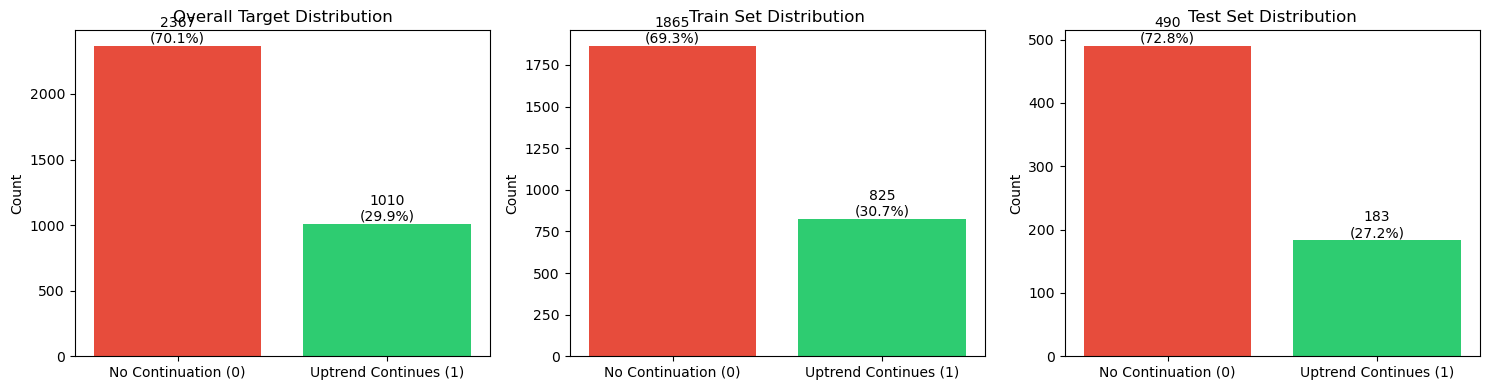


Class balance ratio (Uptrend Continues/No Continuation): 0.427


In [103]:
# Plot class distribution to check for imbalance
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Overall class distribution
unique, counts = np.unique(y_all, return_counts=True)
axes[0].bar(['No Continuation (0)', 'Uptrend Continues (1)'], counts, color=['#e74c3c', '#2ecc71'])
axes[0].set_ylabel('Count')
axes[0].set_title('Overall Target Distribution')
for i, (label, count) in enumerate(zip(['No Continuation (0)', 'Uptrend Continues (1)'], counts)):
    axes[0].text(i, count, f'{count}\n({count/len(y_all)*100:.1f}%)', ha='center', va='bottom')

# Train set distribution
unique_train, counts_train = np.unique(y_train, return_counts=True)
axes[1].bar(['No Continuation (0)', 'Uptrend Continues (1)'], counts_train, color=['#e74c3c', '#2ecc71'])
axes[1].set_ylabel('Count')
axes[1].set_title('Train Set Distribution')
for i, (label, count) in enumerate(zip(['No Continuation (0)', 'Uptrend Continues (1)'], counts_train)):
    axes[1].text(i, count, f'{count}\n({count/len(y_train)*100:.1f}%)', ha='center', va='bottom')

# Test set distribution
unique_test, counts_test = np.unique(y_test, return_counts=True)
axes[2].bar(['No Continuation (0)', 'Uptrend Continues (1)'], counts_test, color=['#e74c3c', '#2ecc71'])
axes[2].set_ylabel('Count')
axes[2].set_title('Test Set Distribution')
for i, (label, count) in enumerate(zip(['No Continuation (0)', 'Uptrend Continues (1)'], counts_test)):
    axes[2].text(i, count, f'{count}\n({count/len(y_test)*100:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f'\nClass balance ratio (Uptrend Continues/No Continuation): {counts[1]/counts[0]:.3f}')

In [104]:
# Scaling: Use RobustScaler for better handling of outliers in crypto data
n_features = X_train.shape[2]
scaler = RobustScaler()  # More robust to outliers than MinMaxScaler
# reshape (num_train_samples * window_size, n_features)
X_train_reshaped = X_train.reshape(-1, n_features)
scaler.fit(X_train_reshaped)
# transform train and test, preserve 3D shape for LSTM/GRU
X_train_scaled = scaler.transform(X_train_reshaped).reshape(X_train.shape)
X_test_reshaped = X_test.reshape(-1, n_features)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

# Final tensors for LSTM
X_train_3d = X_train_scaled  # shape: (samples, window_size, features)
X_test_3d = X_test_scaled

print('✓ Using RobustScaler (better for crypto volatility)')
print('3D shape (for LSTM):', X_train_3d.shape, X_test_3d.shape)

✓ Using RobustScaler (better for crypto volatility)
3D shape (for LSTM): (2690, 14, 13) (673, 14, 13)


In [105]:
# LSTM model with attention and focal loss
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Add, LayerNormalization, MultiHeadAttention, BatchNormalization
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import tensorflow.keras.backend as K

# Focal Loss for handling class imbalance
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * y_true * K.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma)
        loss = weight * cross_entropy
        return K.mean(loss, axis=-1)
    return focal_loss_fixed

def build_lstm_model(window_size, n_features, lr=2e-4, dropout_rate=0.3):
    inputs = Input(shape=(window_size, n_features))
    # First Bi-LSTM layer
    x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.0005)))(inputs)
    x = LayerNormalization()(x)
    x = Dropout(dropout_rate)(x)
    # Second Bi-LSTM layer
    x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0005)))(x)
    x = LayerNormalization()(x)
    x = Dropout(dropout_rate)(x)
    # Attention mechanism (if enabled)
    if USE_ATTENTION:
        attention_output = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
        x = Add()([x, attention_output])  # Residual connection
        x = LayerNormalization()(x)
    # Final LSTM layer
    x = LSTM(32, return_sequences=False, kernel_regularizer=l2(0.0005))(x)
    x = Dropout(dropout_rate)(x)
    # Dense layers
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate * 0.7)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate * 0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    opt = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)
    loss_fn = focal_loss() if USE_FOCAL_LOSS else 'binary_crossentropy'
    model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
    return model

# Build LSTM
n_features = X_train_3d.shape[2]
model = build_lstm_model(WINDOW_SIZE, n_features)
print('\nBuilt LSTM model with attention:', USE_ATTENTION)
model.summary()


Built LSTM model with attention: True


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 14, 13)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_10    │ (None, 14, 256)   │    145,408 │ input_layer_5[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 14, 256)   │        512 │ bidirectional_10… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 14, 256)   │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_11    │ (None, 14, 128)   │    164,352 │ dropout_30[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 14, 128)   │        256 │ bidirectional_11… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 14, 128)   │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 14, 128)   │     66,048 │ dropout_31[0][0], │
│ (MultiHeadAttentio… │                   │            │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 14, 128)   │          0 │ dropout_31[0][0], │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 14, 128)   │        256 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ (None, 32)        │     20,608 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 32)        │          0 │ lstm_17[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │      2,112 │ dropout_33[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_15[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 32)        │      2,080 │ dropout_34[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 32)        │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         33 │ dropout_35[0][0]

 Total params: 401,921 (1.53 MB)

 Trainable params: 401,793 (1.53 MB)

 Non-trainable params: 128 (512.00 B)

In [106]:
# Train the LSTM with improved training strategy and explicit validation
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np

# Compute class weights
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}
print('Class weights:', class_weights)

# # Calculate weights based on Training data only
# class_weights = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )
# class_weight_dict = dict(enumerate(class_weights))

# Learning rate schedule with warmup
def lr_schedule(epoch, lr):
    if epoch < 5:
        return lr * (epoch + 1) / 5
    elif epoch < 30:
        return lr
    elif epoch < 60:
        return lr * 0.5
    elif epoch < 90:
        return lr * 0.25
    else:
        return lr * 0.1

es = EarlyStopping(monitor='val_auc', patience=25, restore_best_weights=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=10, min_lr=1e-7, mode='max', verbose=1)
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)
checkpoint = ModelCheckpoint('best_model_temp.h5', monitor='val_auc', mode='max', save_best_only=True, verbose=1)

# Chronological explicit validation from tail of training
val_ratio = 0.15
val_size = int(len(X_train_3d) * val_ratio)
X_val = X_train_3d[-val_size:]
y_val = y_train[-val_size:]
X_train_final = X_train_3d[:-val_size]
y_train_final = y_train[:-val_size]

print(f'\n🎯 Training samples: {len(X_train_final)}  |  Validation: {len(X_val)}  |  Test: {len(X_test_3d)}')
print(f'Using focal loss: {USE_FOCAL_LOSS}, Batch size: 64')

history = model.fit(
    X_train_final, y_train_final,
    epochs=200,
    batch_size=64,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[es, reduce_lr, lr_scheduler, checkpoint],
    shuffle=False,
    verbose=2
)

print(f'\n✅ Training completed!')
print(f'Total epochs: {len(history.history["loss"])}')
print(f'Best val_loss: {min(history.history["val_loss"]):.4f}')
print(f'Best val_auc: {max(history.history["val_auc"]):.4f}')
if 'val_precision' in history.history:
    print(f'Best val_precision: {max(history.history["val_precision"]):.4f}')
    print(f'Best val_recall: {max(history.history["val_recall"]):.4f}')

Class weights: {0: 0.7211796246648794, 1: 1.6303030303030304}

🎯 Training samples: 2287  |  Validation: 403  |  Test: 673
Using focal loss: True, Batch size: 64
Epoch 1/200
Epoch 1/200

Epoch 1: val_auc improved from -inf to 0.60454, saving model to best_model_temp.h5

Epoch 1: val_auc improved from -inf to 0.60454, saving model to best_model_temp.h5


36/36 - 7s - 196ms/step - accuracy: 0.6056 - auc: 0.5022 - loss: 0.5078 - precision: 0.3405 - recall: 0.2112 - val_accuracy: 0.6873 - val_auc: 0.6045 - val_loss: 0.4621 - val_precision: 0.2353 - val_recall: 0.3333 - learning_rate: 4.0000e-05
Epoch 2/200
Epoch 2/200

Epoch 2: val_auc improved from 0.60454 to 0.60593, saving model to best_model_temp.h5

Epoch 2: val_auc improved from 0.60454 to 0.60593, saving model to best_model_temp.h5


36/36 - 1s - 40ms/step - accuracy: 0.6301 - auc: 0.5412 - loss: 0.4954 - precision: 0.4009 - recall: 0.2497 - val_accuracy: 0.6725 - val_auc: 0.6059 - val_loss: 0.4637 - val_precision: 0.2414 - val_recall: 0.3889 - learning_rate: 1.6000e-05
Epoch 3/200
Epoch 3/200

Epoch 3: val_auc did not improve from 0.60593
36/36 - 2s - 45ms/step - accuracy: 0.6213 - auc: 0.5429 - loss: 0.4905 - precision: 0.3713 - recall: 0.2165 - val_accuracy: 0.6824 - val_auc: 0.5994 - val_loss: 0.4634 - val_precision: 0.2500 - val_recall: 0.3889 - learning_rate: 9.6000e-06
Epoch 4/200

Epoch 3: val_auc did not improve from 0.60593
36/36 - 2s - 45ms/step - accuracy: 0.6213 - auc: 0.5429 - loss: 0.4905 - precision: 0.3713 - recall: 0.2165 - val_accuracy: 0.6824 - val_auc: 0.5994 - val_loss: 0.4634 - val_precision: 0.2500 - val_recall: 0.3889 - learning_rate: 9.6000e-06
Epoch 4/200

Epoch 4: val_auc did not improve from 0.60593
36/36 - 2s - 55ms/step - accuracy: 0.6218 - auc: 0.5359 - loss: 0.4921 - precision: 0.37

36/36 - 2s - 56ms/step - accuracy: 0.6336 - auc: 0.5742 - loss: 0.4838 - precision: 0.4074 - recall: 0.2483 - val_accuracy: 0.7097 - val_auc: 0.6065 - val_loss: 0.4492 - val_precision: 0.2680 - val_recall: 0.3611 - learning_rate: 3.8400e-06
Epoch 16/200
Epoch 16/200

Epoch 16: val_auc improved from 0.60654 to 0.60767, saving model to best_model_temp.h5

Epoch 16: val_auc improved from 0.60654 to 0.60767, saving model to best_model_temp.h5


36/36 - 2s - 59ms/step - accuracy: 0.6296 - auc: 0.5570 - loss: 0.4843 - precision: 0.3932 - recall: 0.2297 - val_accuracy: 0.7097 - val_auc: 0.6077 - val_loss: 0.4491 - val_precision: 0.2632 - val_recall: 0.3472 - learning_rate: 3.8400e-06
Epoch 17/200
Epoch 17/200

Epoch 17: val_auc improved from 0.60767 to 0.60868, saving model to best_model_temp.h5

Epoch 17: val_auc improved from 0.60767 to 0.60868, saving model to best_model_temp.h5


36/36 - 2s - 61ms/step - accuracy: 0.6366 - auc: 0.5709 - loss: 0.4795 - precision: 0.4133 - recall: 0.2470 - val_accuracy: 0.7122 - val_auc: 0.6087 - val_loss: 0.4489 - val_precision: 0.2708 - val_recall: 0.3611 - learning_rate: 3.8400e-06
Epoch 18/200
Epoch 18/200

Epoch 18: val_auc improved from 0.60868 to 0.60901, saving model to best_model_temp.h5

Epoch 18: val_auc improved from 0.60868 to 0.60901, saving model to best_model_temp.h5


36/36 - 2s - 58ms/step - accuracy: 0.6362 - auc: 0.5897 - loss: 0.4787 - precision: 0.4168 - recall: 0.2629 - val_accuracy: 0.7146 - val_auc: 0.6090 - val_loss: 0.4486 - val_precision: 0.2737 - val_recall: 0.3611 - learning_rate: 3.8400e-06
Epoch 19/200
Epoch 19/200

Epoch 19: val_auc improved from 0.60901 to 0.61042, saving model to best_model_temp.h5

Epoch 19: val_auc improved from 0.60901 to 0.61042, saving model to best_model_temp.h5


36/36 - 2s - 60ms/step - accuracy: 0.6253 - auc: 0.5712 - loss: 0.4823 - precision: 0.3898 - recall: 0.2444 - val_accuracy: 0.7171 - val_auc: 0.6104 - val_loss: 0.4481 - val_precision: 0.2766 - val_recall: 0.3611 - learning_rate: 3.8400e-06
Epoch 20/200
Epoch 20/200

Epoch 20: val_auc improved from 0.61042 to 0.61187, saving model to best_model_temp.h5

Epoch 20: val_auc improved from 0.61042 to 0.61187, saving model to best_model_temp.h5


36/36 - 2s - 56ms/step - accuracy: 0.6458 - auc: 0.5868 - loss: 0.4764 - precision: 0.4397 - recall: 0.2762 - val_accuracy: 0.7146 - val_auc: 0.6119 - val_loss: 0.4472 - val_precision: 0.2688 - val_recall: 0.3472 - learning_rate: 3.8400e-06
Epoch 21/200
Epoch 21/200

Epoch 21: val_auc improved from 0.61187 to 0.61197, saving model to best_model_temp.h5

Epoch 21: val_auc improved from 0.61187 to 0.61197, saving model to best_model_temp.h5


36/36 - 2s - 59ms/step - accuracy: 0.6345 - auc: 0.5784 - loss: 0.4787 - precision: 0.4059 - recall: 0.2377 - val_accuracy: 0.7221 - val_auc: 0.6120 - val_loss: 0.4468 - val_precision: 0.2826 - val_recall: 0.3611 - learning_rate: 3.8400e-06
Epoch 22/200
Epoch 22/200

Epoch 22: val_auc did not improve from 0.61197
36/36 - 2s - 58ms/step - accuracy: 0.6305 - auc: 0.5671 - loss: 0.4821 - precision: 0.4017 - recall: 0.2497 - val_accuracy: 0.7270 - val_auc: 0.6120 - val_loss: 0.4463 - val_precision: 0.2889 - val_recall: 0.3611 - learning_rate: 3.8400e-06
Epoch 23/200

Epoch 22: val_auc did not improve from 0.61197
36/36 - 2s - 58ms/step - accuracy: 0.6305 - auc: 0.5671 - loss: 0.4821 - precision: 0.4017 - recall: 0.2497 - val_accuracy: 0.7270 - val_auc: 0.6120 - val_loss: 0.4463 - val_precision: 0.2889 - val_recall: 0.3611 - learning_rate: 3.8400e-06
Epoch 23/200

Epoch 23: val_auc improved from 0.61197 to 0.61271, saving model to best_model_temp.h5

Epoch 23: val_auc improved from 0.61197 

36/36 - 2s - 60ms/step - accuracy: 0.6415 - auc: 0.5787 - loss: 0.4788 - precision: 0.4286 - recall: 0.2669 - val_accuracy: 0.7221 - val_auc: 0.6127 - val_loss: 0.4460 - val_precision: 0.2872 - val_recall: 0.3750 - learning_rate: 3.8400e-06
Epoch 24/200
Epoch 24/200

Epoch 24: val_auc did not improve from 0.61271
36/36 - 2s - 55ms/step - accuracy: 0.6244 - auc: 0.5563 - loss: 0.4818 - precision: 0.3863 - recall: 0.2390 - val_accuracy: 0.7221 - val_auc: 0.6125 - val_loss: 0.4451 - val_precision: 0.2778 - val_recall: 0.3472 - learning_rate: 3.8400e-06
Epoch 25/200

Epoch 24: val_auc did not improve from 0.61271
36/36 - 2s - 55ms/step - accuracy: 0.6244 - auc: 0.5563 - loss: 0.4818 - precision: 0.3863 - recall: 0.2390 - val_accuracy: 0.7221 - val_auc: 0.6125 - val_loss: 0.4451 - val_precision: 0.2778 - val_recall: 0.3472 - learning_rate: 3.8400e-06
Epoch 25/200

Epoch 25: val_auc did not improve from 0.61271
36/36 - 2s - 55ms/step - accuracy: 0.6266 - auc: 0.5590 - loss: 0.4838 - precisio

36/36 - 2s - 55ms/step - accuracy: 0.6310 - auc: 0.5765 - loss: 0.4798 - precision: 0.4062 - recall: 0.2616 - val_accuracy: 0.7246 - val_auc: 0.6142 - val_loss: 0.4427 - val_precision: 0.2593 - val_recall: 0.2917 - learning_rate: 3.8400e-06
Epoch 31/200
Epoch 31/200

Epoch 31: val_auc improved from 0.61415 to 0.61657, saving model to best_model_temp.h5

Epoch 31: val_auc improved from 0.61415 to 0.61657, saving model to best_model_temp.h5


36/36 - 2s - 62ms/step - accuracy: 0.6318 - auc: 0.5787 - loss: 0.4795 - precision: 0.4105 - recall: 0.2709 - val_accuracy: 0.7320 - val_auc: 0.6166 - val_loss: 0.4420 - val_precision: 0.2692 - val_recall: 0.2917 - learning_rate: 1.9200e-06
Epoch 32/200
Epoch 32/200

Epoch 32: val_auc improved from 0.61657 to 0.61738, saving model to best_model_temp.h5

Epoch 32: val_auc improved from 0.61657 to 0.61738, saving model to best_model_temp.h5


36/36 - 2s - 58ms/step - accuracy: 0.6296 - auc: 0.5601 - loss: 0.4829 - precision: 0.3996 - recall: 0.2483 - val_accuracy: 0.7345 - val_auc: 0.6174 - val_loss: 0.4416 - val_precision: 0.2727 - val_recall: 0.2917 - learning_rate: 9.6000e-07
Epoch 33/200
Epoch 33/200

Epoch 33: val_auc did not improve from 0.61738
36/36 - 2s - 54ms/step - accuracy: 0.6401 - auc: 0.5929 - loss: 0.4729 - precision: 0.4289 - recall: 0.2802 - val_accuracy: 0.7320 - val_auc: 0.6174 - val_loss: 0.4419 - val_precision: 0.2632 - val_recall: 0.2778 - learning_rate: 4.8000e-07
Epoch 34/200

Epoch 33: val_auc did not improve from 0.61738
36/36 - 2s - 54ms/step - accuracy: 0.6401 - auc: 0.5929 - loss: 0.4729 - precision: 0.4289 - recall: 0.2802 - val_accuracy: 0.7320 - val_auc: 0.6174 - val_loss: 0.4419 - val_precision: 0.2632 - val_recall: 0.2778 - learning_rate: 4.8000e-07
Epoch 34/200

Epoch 34: val_auc did not improve from 0.61738
36/36 - 2s - 54ms/step - accuracy: 0.6498 - auc: 0.5994 - loss: 0.4760 - precisio

36/36 - 2s - 56ms/step - accuracy: 0.6366 - auc: 0.5716 - loss: 0.4800 - precision: 0.4129 - recall: 0.2457 - val_accuracy: 0.7370 - val_auc: 0.6181 - val_loss: 0.4416 - val_precision: 0.2639 - val_recall: 0.2639 - learning_rate: 1.1444e-13
Epoch 56/200
Epoch 56/200

Epoch 56: val_auc improved from 0.61814 to 0.61873, saving model to best_model_temp.h5

Epoch 56: val_auc improved from 0.61814 to 0.61873, saving model to best_model_temp.h5


36/36 - 2s - 59ms/step - accuracy: 0.6292 - auc: 0.5732 - loss: 0.4779 - precision: 0.3965 - recall: 0.2417 - val_accuracy: 0.7395 - val_auc: 0.6187 - val_loss: 0.4417 - val_precision: 0.2740 - val_recall: 0.2778 - learning_rate: 5.7220e-14
Epoch 57/200
Epoch 57/200

Epoch 57: val_auc did not improve from 0.61873
36/36 - 2s - 59ms/step - accuracy: 0.6428 - auc: 0.5810 - loss: 0.4790 - precision: 0.4322 - recall: 0.2709 - val_accuracy: 0.7395 - val_auc: 0.6181 - val_loss: 0.4416 - val_precision: 0.2740 - val_recall: 0.2778 - learning_rate: 2.8610e-14
Epoch 58/200

Epoch 57: val_auc did not improve from 0.61873
36/36 - 2s - 59ms/step - accuracy: 0.6428 - auc: 0.5810 - loss: 0.4790 - precision: 0.4322 - recall: 0.2709 - val_accuracy: 0.7395 - val_auc: 0.6181 - val_loss: 0.4416 - val_precision: 0.2740 - val_recall: 0.2778 - learning_rate: 2.8610e-14
Epoch 58/200

Epoch 58: val_auc did not improve from 0.61873
36/36 - 2s - 59ms/step - accuracy: 0.6222 - auc: 0.5629 - loss: 0.4804 - precisio

Selected threshold (max F1): 0.3549

Confusion Matrix @ tuned threshold:
[[292 198]
 [ 65 118]]

Classification Report @ tuned threshold:
                precision    recall  f1-score   support

Down/Equal (0)     0.8179    0.5959    0.6895       490
        Up (1)     0.3734    0.6448    0.4729       183

      accuracy                         0.6092       673
     macro avg     0.5957    0.6204    0.5812       673
  weighted avg     0.6971    0.6092    0.6306       673


Confusion Matrix @ tuned threshold:
[[292 198]
 [ 65 118]]

Classification Report @ tuned threshold:
                precision    recall  f1-score   support

Down/Equal (0)     0.8179    0.5959    0.6895       490
        Up (1)     0.3734    0.6448    0.4729       183

      accuracy                         0.6092       673
     macro avg     0.5957    0.6204    0.5812       673
  weighted avg     0.6971    0.6092    0.6306       673



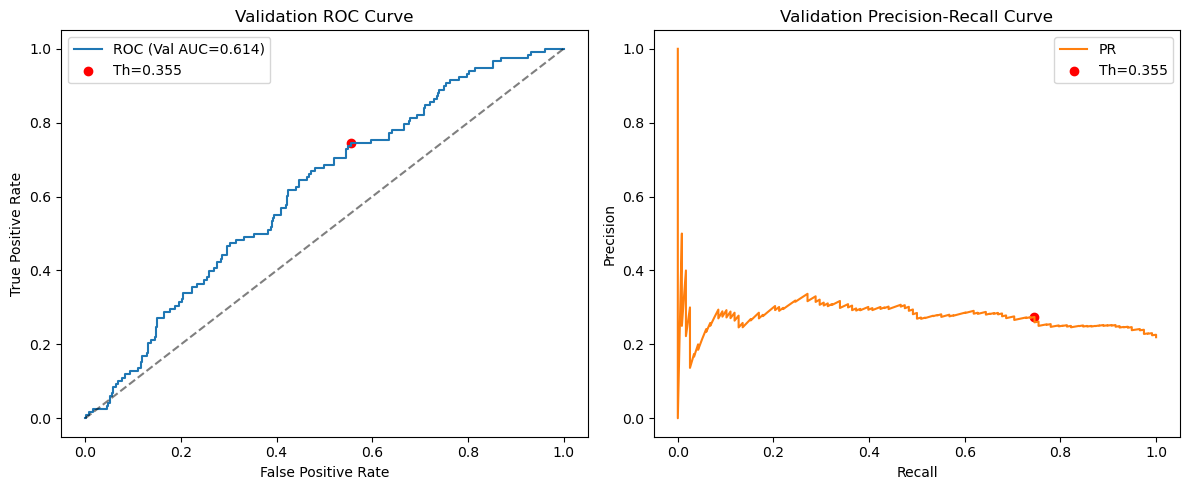

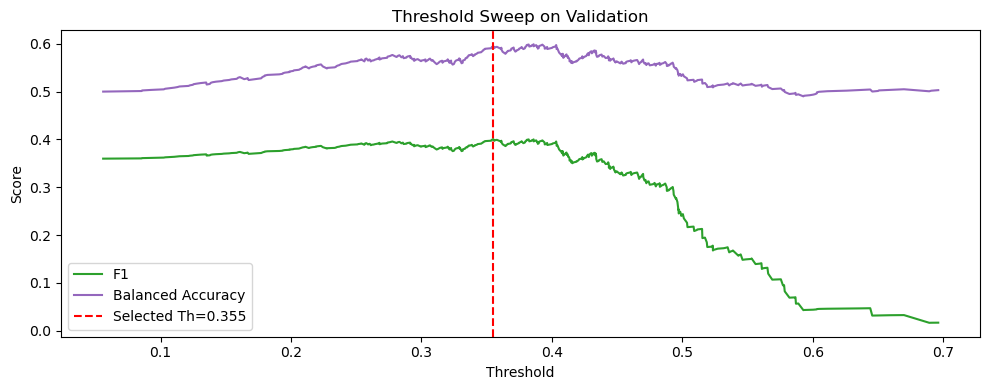

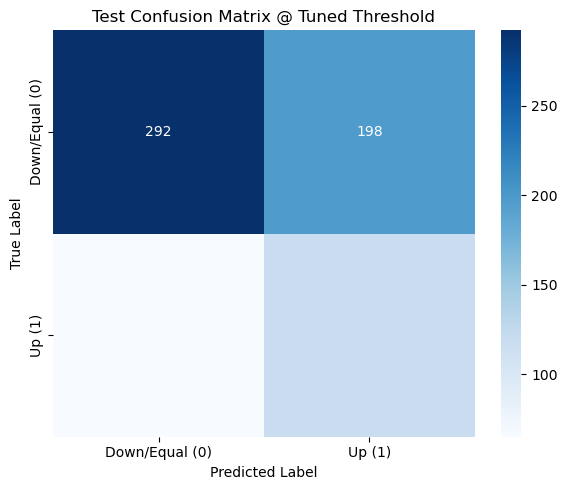

In [107]:
# Threshold tuning on validation for LSTM (balanced-aware) with plots
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report, confusion_matrix, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Validation split from tail of training (chronological) ---
val_ratio = 0.20
val_size = int(len(X_train_3d) * val_ratio)
X_val = X_train_3d[-val_size:]
y_val = y_train[-val_size:]

# --- Predict probabilities on validation ---
val_probs = model.predict(X_val, verbose=0).ravel()

# --- Compute ROC and PR curves ---
fpr, tpr, roc_thr = roc_curve(y_val, val_probs)
precision, recall, pr_thr = precision_recall_curve(y_val, val_probs)
auc_val = roc_auc_score(y_val, val_probs)

# Candidate thresholds (exclude last inf)
threshold_grid = pr_thr[:-1]

# --- Track best thresholds and metrics for plotting ---
best = {
    'f1': -1, 'thr_f1': 0.5,
    'bal_acc': -1, 'thr_bal': 0.5,
    'youden_j': -1, 'thr_j': 0.5
}
thr_list, f1_list, bal_acc_list = [], [], []

for thr in threshold_grid:
    y_hat = (val_probs >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_hat).ravel()

    # Metrics with small epsilon to avoid zero division
    prec = tp / (tp + fp + 1e-8)
    rec = tp / (tp + fn + 1e-8)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)
    bal_acc = (tp/(tp+fn+1e-8) + tn/(tn+fp+1e-8)) / 2

    thr_list.append(thr); f1_list.append(f1); bal_acc_list.append(bal_acc)

    # Youden's J (maximize TPR - FPR) from ROC
    j_scores = tpr - fpr
    j_idx = np.argmax(j_scores)
    youden_thr = roc_thr[j_idx]

    # Track best thresholds
    if f1 > best['f1']:
        best['f1'] = f1
        best['thr_f1'] = thr
    if bal_acc > best['bal_acc']:
        best['bal_acc'] = bal_acc
        best['thr_bal'] = thr
    if j_scores[j_idx] > best['youden_j']:
        best['youden_j'] = j_scores[j_idx]
        best['thr_j'] = youden_thr

# --- Select threshold for balanced performance ---
threshold_to_use = best['thr_f1']  # choose max F1 or use 'thr_bal' for better class balance
print(f"Selected threshold (max F1): {threshold_to_use:.4f}")

# --- Apply threshold on test set ---
probs_test = model.predict(X_test_3d, verbose=0).ravel()
y_pred_optimal = (probs_test >= threshold_to_use).astype(int)

# --- Evaluation ---
cm = confusion_matrix(y_test, y_pred_optimal)
print("\nConfusion Matrix @ tuned threshold:")
print(cm)

print("\nClassification Report @ tuned threshold:")
print(classification_report(
    y_test,
    y_pred_optimal,
    target_names=['Down/Equal (0)', 'Up (1)'],
    digits=4
))

# --- Plots: ROC/PR curves, threshold vs metrics, CM heatmap ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'ROC (Val AUC={auc_val:.3f})', color='#1f77b4')
plt.plot([0,1],[0,1],'k--',alpha=0.5)
# Mark point closest to selected threshold on ROC
idx_thr_roc = np.argmin(np.abs(roc_thr - threshold_to_use))
plt.scatter(fpr[idx_thr_roc], tpr[idx_thr_roc], color='red', label=f'Th={threshold_to_use:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(recall, precision, label='PR', color='#ff7f0e')
# Mark point closest to selected threshold on PR
idx_thr_pr = np.argmin(np.abs(pr_thr - threshold_to_use))
idx_thr_pr = np.clip(idx_thr_pr, 0, len(precision)-1)
plt.scatter(recall[idx_thr_pr], precision[idx_thr_pr], color='red', label=f'Th={threshold_to_use:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Validation Precision-Recall Curve')
plt.legend()
plt.tight_layout()
plt.show()

# Threshold vs F1 and Balanced Accuracy
plt.figure(figsize=(10,4))
plt.plot(thr_list, f1_list, label='F1', color='#2ca02c')
plt.plot(thr_list, bal_acc_list, label='Balanced Accuracy', color='#9467bd')
plt.axvline(threshold_to_use, color='red', linestyle='--', label=f'Selected Th={threshold_to_use:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Sweep on Validation')
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix Heatmap (Test @ tuned threshold)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Down/Equal (0)', 'Up (1)'],
            yticklabels=['Down/Equal (0)', 'Up (1)'])
plt.title('Test Confusion Matrix @ Tuned Threshold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

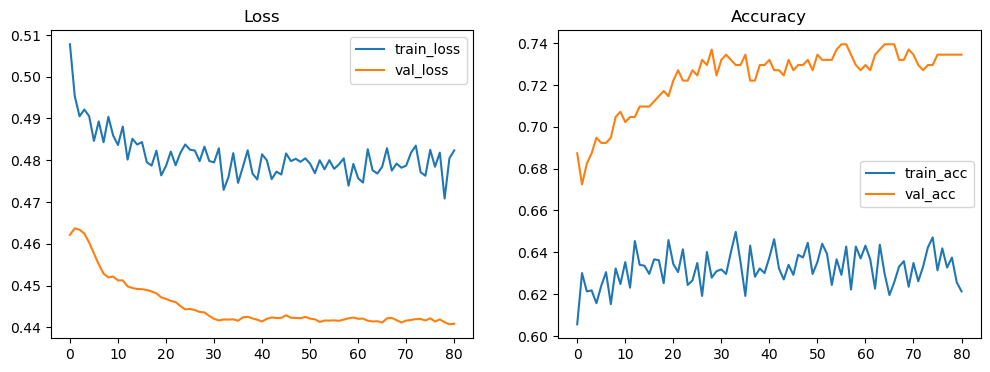

In [108]:
# Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()

In [109]:
# Evaluate on test set (consistent tensors)
results = model.evaluate(X_test_3d, y_test, verbose=0)
print('\nLSTM Test Results:')
print(f'  Loss: {results[0]:.4f}')
print(f'  Accuracy: {results[1]:.4f}')
print(f'  AUC: {results[2]:.4f}')
if len(results) > 3:
    print(f'  Precision: {results[3]:.4f}')
    print(f'  Recall: {results[4]:.4f}')
    f1 = 2 * (results[3] * results[4]) / (results[3] + results[4] + 1e-7)
    print(f'  F1-Score: {f1:.4f}')


LSTM Test Results:
  Loss: 0.4339
  Accuracy: 0.7132
  AUC: 0.6517
  Precision: 0.4375
  Recall: 0.1913
  F1-Score: 0.2662


In [110]:
# Save model (optional)
model.save('btc_dense_model.h5')
print('Saved model to btc_dense_model.h5')

Saved model to btc_dense_model.h5
